### 1. Understanding Unicode

* (a) `\x00`
* (b) The printed representation is white space.
* (c) When string is evaluated, it appear as `\x00`. When the string is printed, it appear as white space.

### 2. Unicode Encodings
* (a) UTF-16 or -32 encode all unicode into at least 2 or 4 bytes. But UTF-8 includes some unicode to a single byte. This makes the output byte sequence shorter.
* (b) `'😧'.encode('utf-8')`. We should decode by iterate over the bytes, there are some cases where a multiple bytes corresponds to one unicode string.
* (c) `'\xC0\xC0'`

### 3. BPE Training on TinyStories

* (a) My `tinystories` take `0.23 hours`. According to `wandb`, it uses `8GB` peak memory and only `0.3GB` long term memory. The longest token is `b' accomplishments'`.
* (b) The longest part is when I call length function to access if my vocab length has met the goal. The next most time consuming part is when I call the `max` function to find the most frequent pair.

### 4. BPE Training on OpenWebText

* (a) The longest voacb is
```
b'\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82\xc3\x83\xc3\x82'
```
* (b) The vocabulary for OpenWebText is much more complex than tinystories.

### 5. Experiments with tokenizers

```
(cs336_basics) [zitong@sh03-18n13 /home/groups/candes/zitong/cs336-assignment1-basics] (job 44602574) $ python cs336_basics/scripts/tokenizer_experiments.py 
--------------------------------------------------
Sample text from TinyStory:

Once upon a time there was a little boy named Ben ...
Estimated compression ratio for TinyStory: 1.7282659228265922
Estimated throughput for TinyStory: 336814.56619179796 bytes/sec
--------------------------------------------------
Sample text from OpenWebText:
What wouldn't you do to save someone you love?

Wh ...
Estimated compression ratio for OpenWebText: 4.7143284922892645
Estimated throughput for OpenWebText: 449234.81205524184 bytes/sec
--------------------------------------------------
Estimated compression ratio for OpenWebText using TinyStory tokenizer: 1.7201311117181097
```

* (a) The compression ratio for TinyStories is `1.7282659228265922` and for OpenWebText is `4.7143284922892645`.
* (b) If we use TinyStories tokenizer for OpenWebText, the compression ratio is `1.7201311117181097`.
* (c) The throughput for TinyStories is `336814.56619179796 bytes/sec` and for OpenWebText is `449234.81205524184 bytes/sec`. If we use this throughput on Pile with 825GB of text, it will take `(8.25e+11/449234.81205524184)/3600=510` hours.
* (d) `uint16` is an appropriate choice as it is unsigned, so we don't waste a bit on the sign. It is also 2 bytes long, which is enough to store the maximum value of 65,535, whereas the vocabulary size is 32,000.

### 6. Transformer LM resource accounting

In [3]:
vocab_size = 50257
context_length = 1024
num_layers = 48
d_model = 1600
num_heads = 25
d_ff = 6400

# calculate the number of trainable parameters in the model
embedding = vocab_size * d_model + context_length * d_model
multihead = 3 * d_model * d_model + d_model * d_model
ffn = d_model * d_ff + d_ff * d_model
transformer_block = d_model + multihead + d_model + ffn
lm_head = d_model * vocab_size
transformer_lm = embedding + num_layers * transformer_block + d_model + lm_head
print(f"Number of trainable parameters in GPT2-XL: {transformer_lm}")

Number of trainable parameters in GPT2-XL: 1637176000


#### Memory accounting

| Model   | Vocab Size | Context Length | Num Layers | d_model | d_ff | Embedding | FFN        | Attn       | Total Param | Percent FFN | Percent Attn | Percent Emb  | Memory (GB) |
|---------|------------|----------------|------------|---------|------|-----------|------------|------------|-------------|-------------|--------------|--------------|-------------|
| GPT2-XL | 50257      | 1024           | 48         | 1600    | 6400 | 162462400 | 983116800  | 491596800  | 1637176000  | 0.600495487 | 0.300271199  | 0.099233314  | 6.548704    |
| GPT2-L  | 50257      | 1024           | 36         | 1280    | 5120 | 129969920 | 471905280  | 235975680  | 837850880   | 0.563233018 | 0.281644008  | 0.155122974  | 3.35140352  |
| GPT2-M  | 50257      | 1024           | 24         | 1024    | 4096 | 103975936 | 201351168  | 100687872  | 406014976   | 0.495920545 | 0.247990537  | 0.256088918  | 1.624059904 |
| GPT2-S  | 50257      | 1024           | 12         | 768     | 3072 | 77981952  | 56632320   | 28320768   | 162935040   | 0.347576065 | 0.173816314  | 0.478607622  | 0.65174016  |


* (a) See above. Memory size is `(1637176000*4)/(10**9)=6.5 GB`. See below for FLOPs accounting. 
* (b) The emebdding layer requires most FLOPs.
* (c) As the model size increases, the fraction of FLOPSs taken by MLP increases most dramatically.
* (d) With longer context, attention begin to take more FLOPs then FFN.

#### FLOPs accounting

| Model   | Vocab Size | Context Length | Num Layers | d_model | d_ff  | emb_FLOPs    | ffn_FLOPs  | attn_FLOPs | total_FLOPs  | Percent Emb  | Percent FFN  | Percent Attn |
|---------|------------|----------------|------------|---------|-------|--------------|------------|------------|--------------|--------------|--------------|--------------|
| GPT2-XL | 50257      | 1024           | 48         | 1600    | 6400  | 164682137600 | 41943040000| 22439526400 | 229064704000 | 0.718932837  | 0.183105643  | 0.097961519  |
| GPT2-L  | 50257      | 1024           | 36         | 1280    | 5120  | 131745710080 | 26843545600| 15435038720 | 174024294400 | 0.757053551  | 0.154251713  | 0.088694735  |
| GPT2-M  | 50257      | 1024           | 24         | 1024    | 4096  | 105396568064 | 17179869184| 10737418240 | 133313855488 | 0.790589753  | 0.128867844  | 0.080542403  |
| GPT2-S  | 50257      | 1024           | 12         | 768     | 3072  | 79047426048  | 9663676416 | 6845104128  | 95556206592  | 0.827234869  | 0.101130808  | 0.071634323  |
|GPT2-XL-Long-Context|	50257|	16384|	48|	1600|	6400|	2634914201600|	671088640000|	1969645158400|	5275648000000|	0.499448447204969|	0.127204968944099|	0.373346583850932|

### 7. Tuning the learning rate

With outrageously high learning rate, the losses diverges. 

### 8. Resource accounting for training with AdamW

* (a) Memory accounting for training with AdamW: Let `num_heads`=$H$, `d_model`=$d$, `bath_size`=$B$, `context_length`=$L$, `vocab_size`=$V$, `num_layers`=$N$. According to the table below, the total memory required is $N[6d+3BHL^2+46d^2+21BLd]+V(BL+4d)+BL$.

|                 | Copies | Parameters | Activation | Gradients | Adam States | Total           |
|-----------------|--------|------------|------------|-----------|-------------|-----------------|
| RMSNorm         | $2N+1$ | $d$        | $BLd$      | $d$       | $2d$        | $d(2N+1)(BL+3)$ |
| $Q/K/V$         | $N$    | 3d^2       | $3BLd$     | $3d^2$    | $6d^2$      | $N(12d^2+3BLd)$ |
| $QK^T$          | $N$    | $0$        | $BHL^2$    | $0$       | $0$         | $NBHL^2$        |
| `softmax`       | $N$    | $0$        | $BHL^2$    | $0$       | $0$         | $NBHL^2$        |
| `weight_sum`    | $N$    | $0$        | $BLd$      | $0$       | $0$         | $NBHL^2$        |
| `projection`    | $N$    | $d^2$      | $BLd$      | $d^2$     | $2d^2$      | $N(2d^2+4BLd)$  |
| $W_1$           | $N$    | $4d^2$     | $4BLd$     | $4d^2$    | $8d^2$      | $N(4BLd+16d^2)$ |
| `GeLU`          | $N$    | $0$        | $4BLd$     | $0$       | $0$         | $4NBLd$         |
| $W_2$           | $N$    | $4d^2$     | $4BLd$     | $4d^2$    | $8d^2$      | $N(4BLd+16d^2)$ |
| `lm_head`       | $1$    | $Vd$       | $BLV$      | $Vd$      | $2Vd$       | $BLV+4Vd$       |
| `cross_entropy` | $1$    | $0$        | $BL$       | $0$       | $0$         | $BL$            |

* (b) The number of floating point needed to strore in memory is $B[3NHL^2+21NLd+L(d+V+1)]+(46Nd^2+6Nd+4Vd+3d)$.


In [7]:
a = 3*num_layers*(context_length**2)+21*num_layers*d_model+context_length + context_length*(d_model+vocab_size+1)
b = 46*num_layers*(d_model**2)+6*num_layers*d_model+4*vocab_size*d_model+3*d_model
print(f'Batch size of B require B * {a*4/(10**9)} GB + {b*4/(10**9)} GB of memory.')
print(f'On a single GPU with 80GB SRAM, the maximum batch size is {int((80 - b*4/(10**9))/(a*4/(10**9)))}.')

Batch size of B require B * 0.82284544 GB + 23.8983616 GB of memory.
On a single GPU with 80GB SRAM, the maximum batch size is 68.


* (c) According to the 

### 9. Tune the learning rate

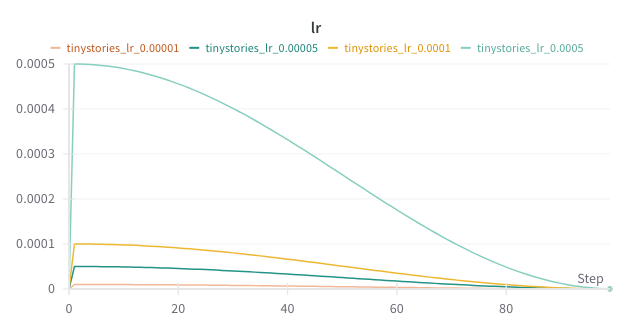

![W&B Chart 4_15_2024, 4_01_21 PM.png](<attachment:W&B Chart 4_15_2024, 4_01_21 PM.png>)
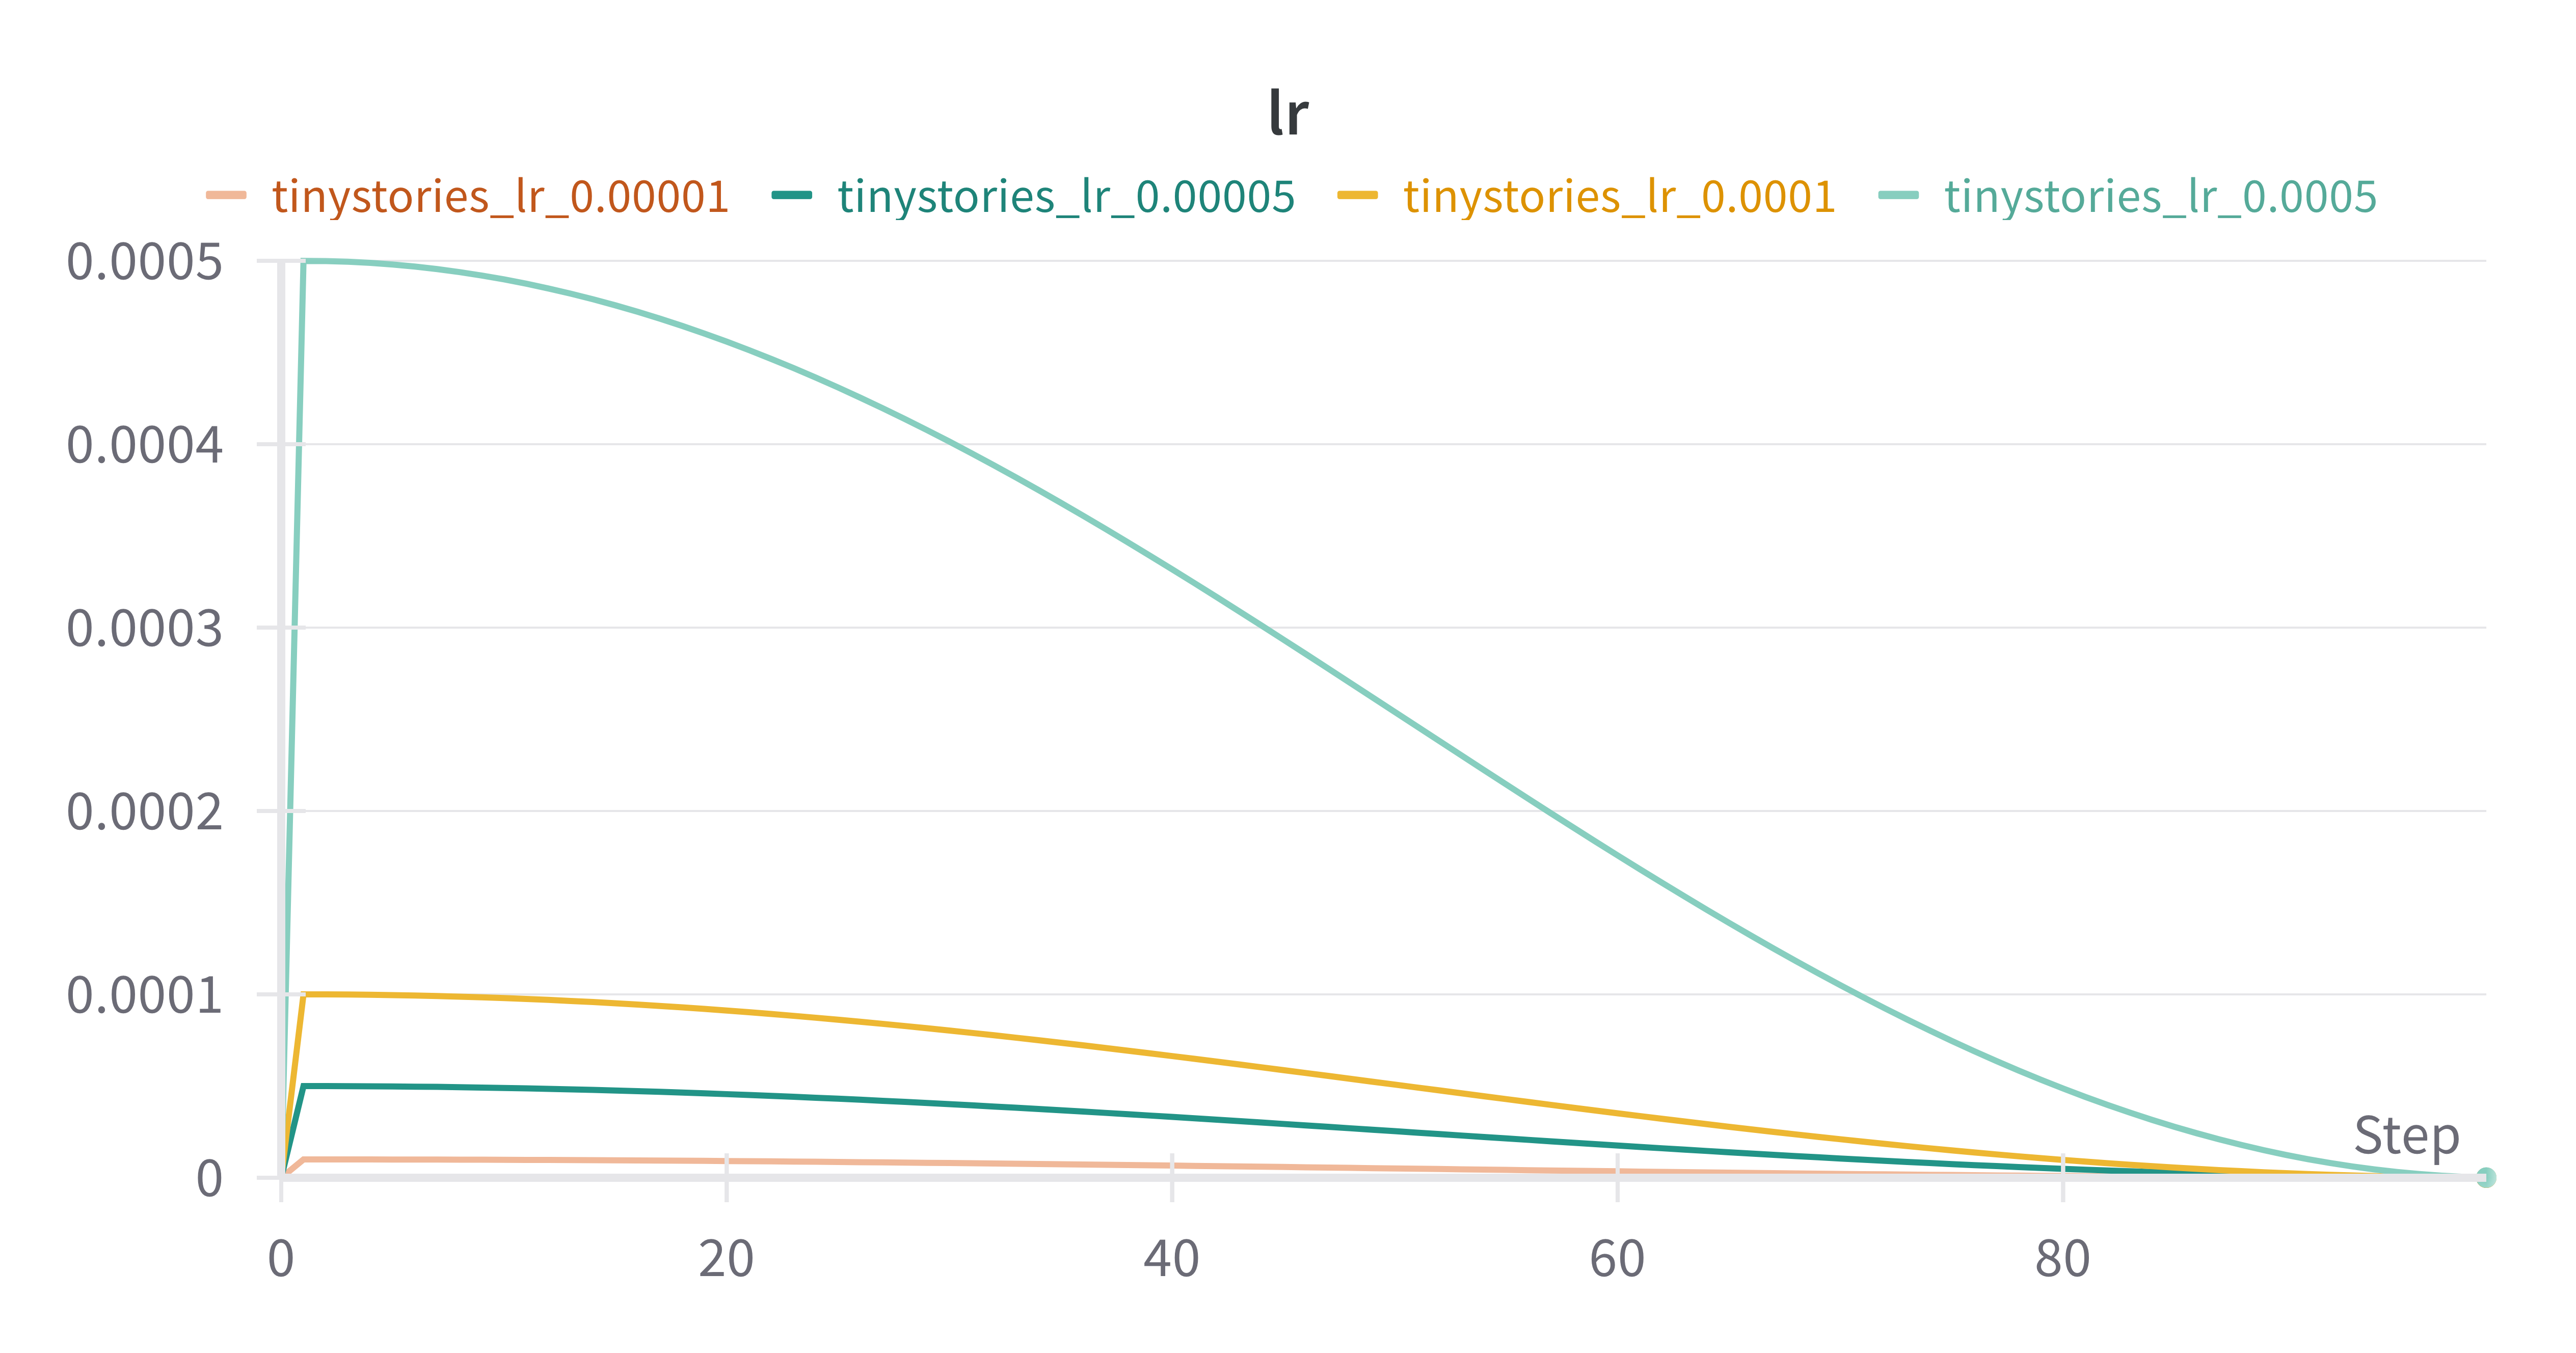

### 10. Batch size variations

![W&B Chart 4_15_2024, 4_05_06 PM.png](<attachment:W&B Chart 4_15_2024, 4_05_06 PM.png>)

We can see that the validation loss for smaller bath size is much nosier, and also converge slower.
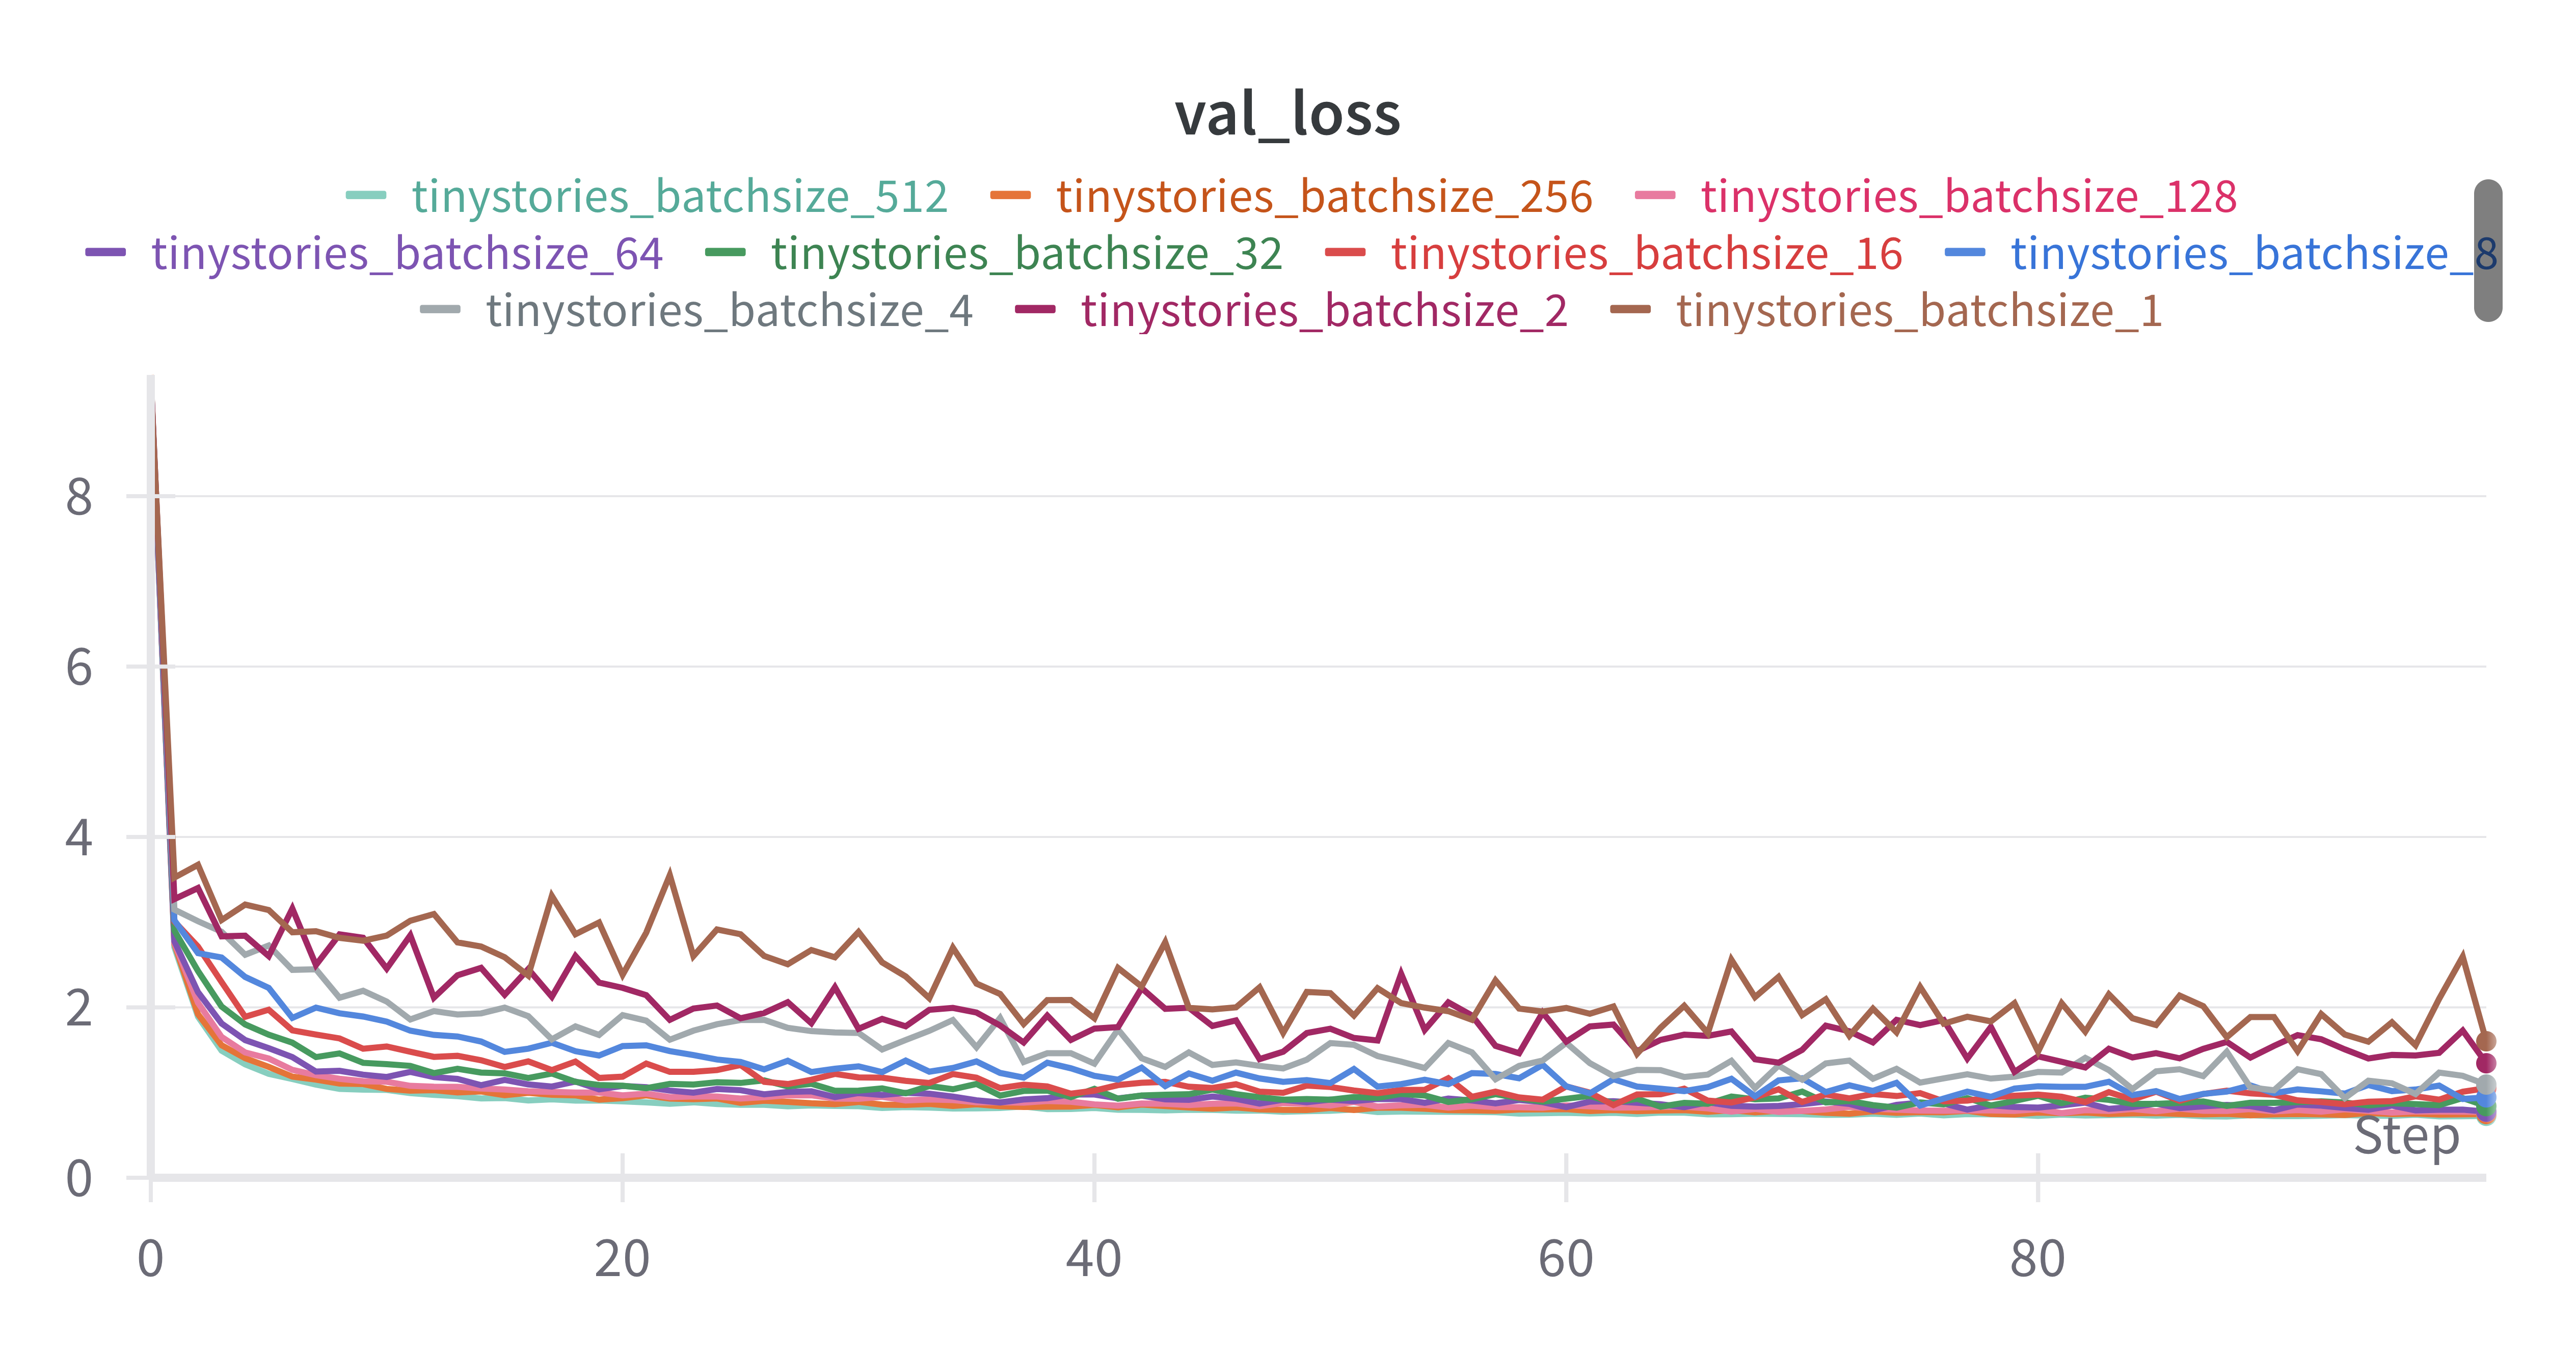

### 11. Generate text

### 12. Experiment with parallel layers

![W&B Chart 4_15_2024, 4_07_50 PM.png](<attachment:W&B Chart 4_15_2024, 4_07_50 PM.png>)

In my experiment, parallel layers have worse performance
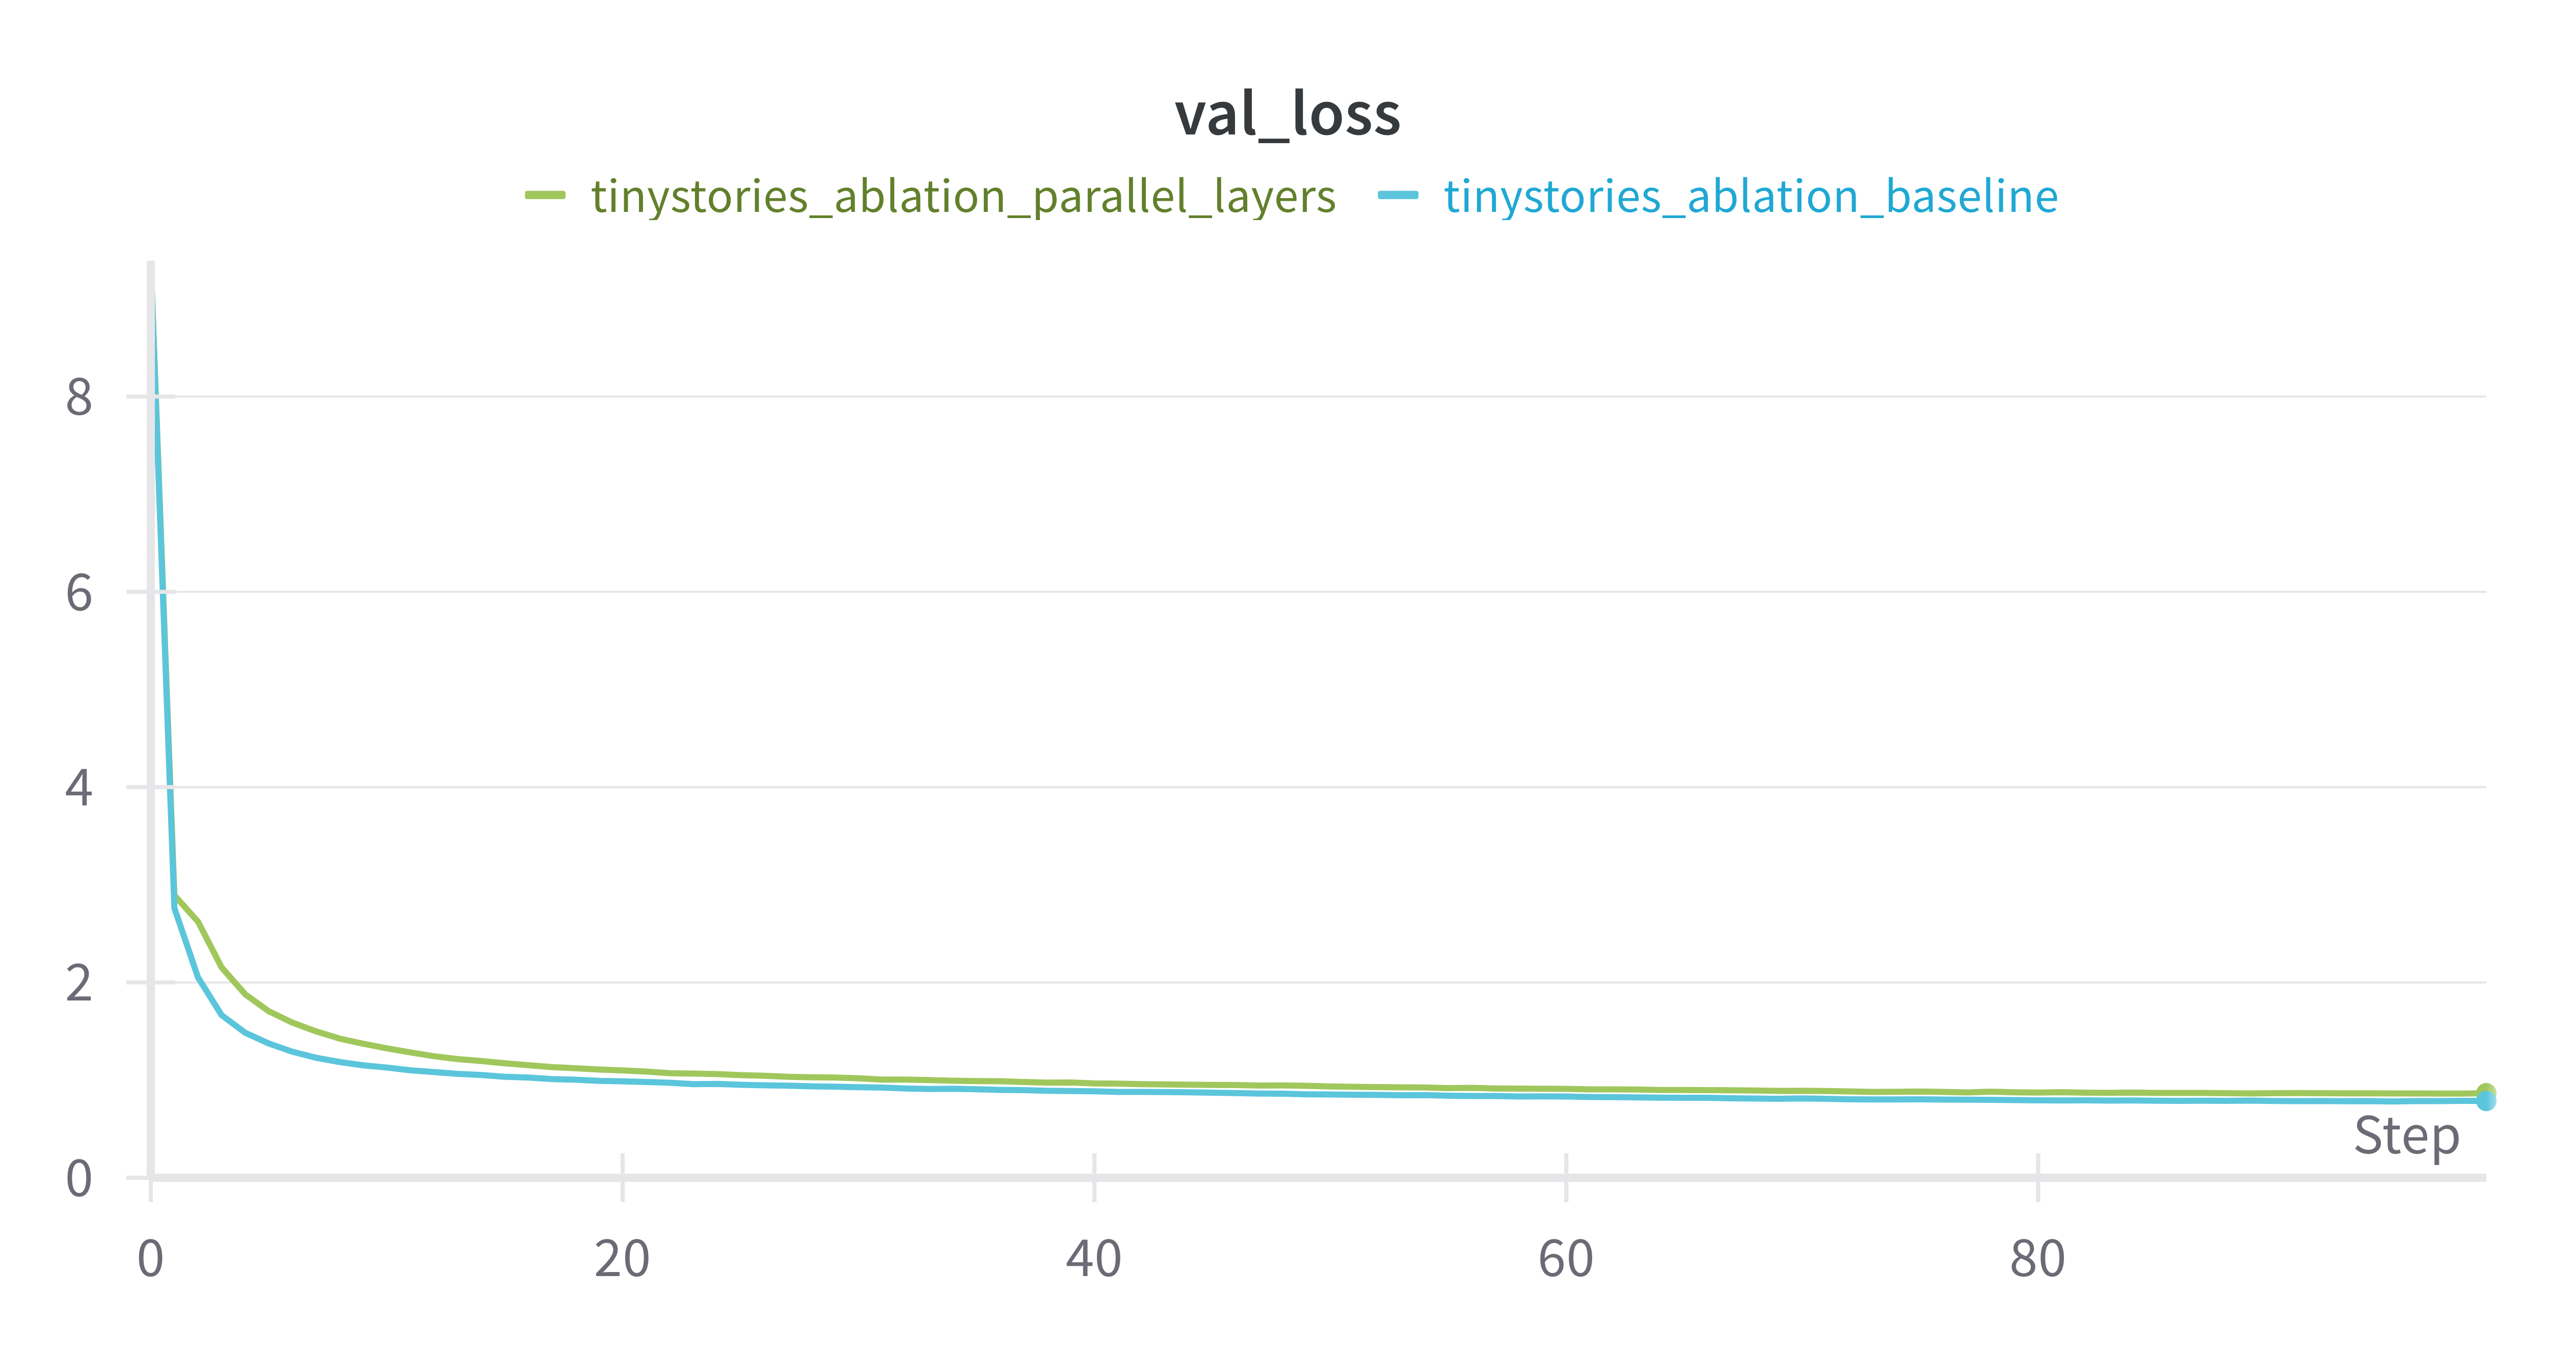

### 13. Remove RMSNorm and train

![W&B Chart 4_15_2024, 4_07_50 PM (1).png](<attachment:W&B Chart 4_15_2024, 4_07_50 PM (1).png>)
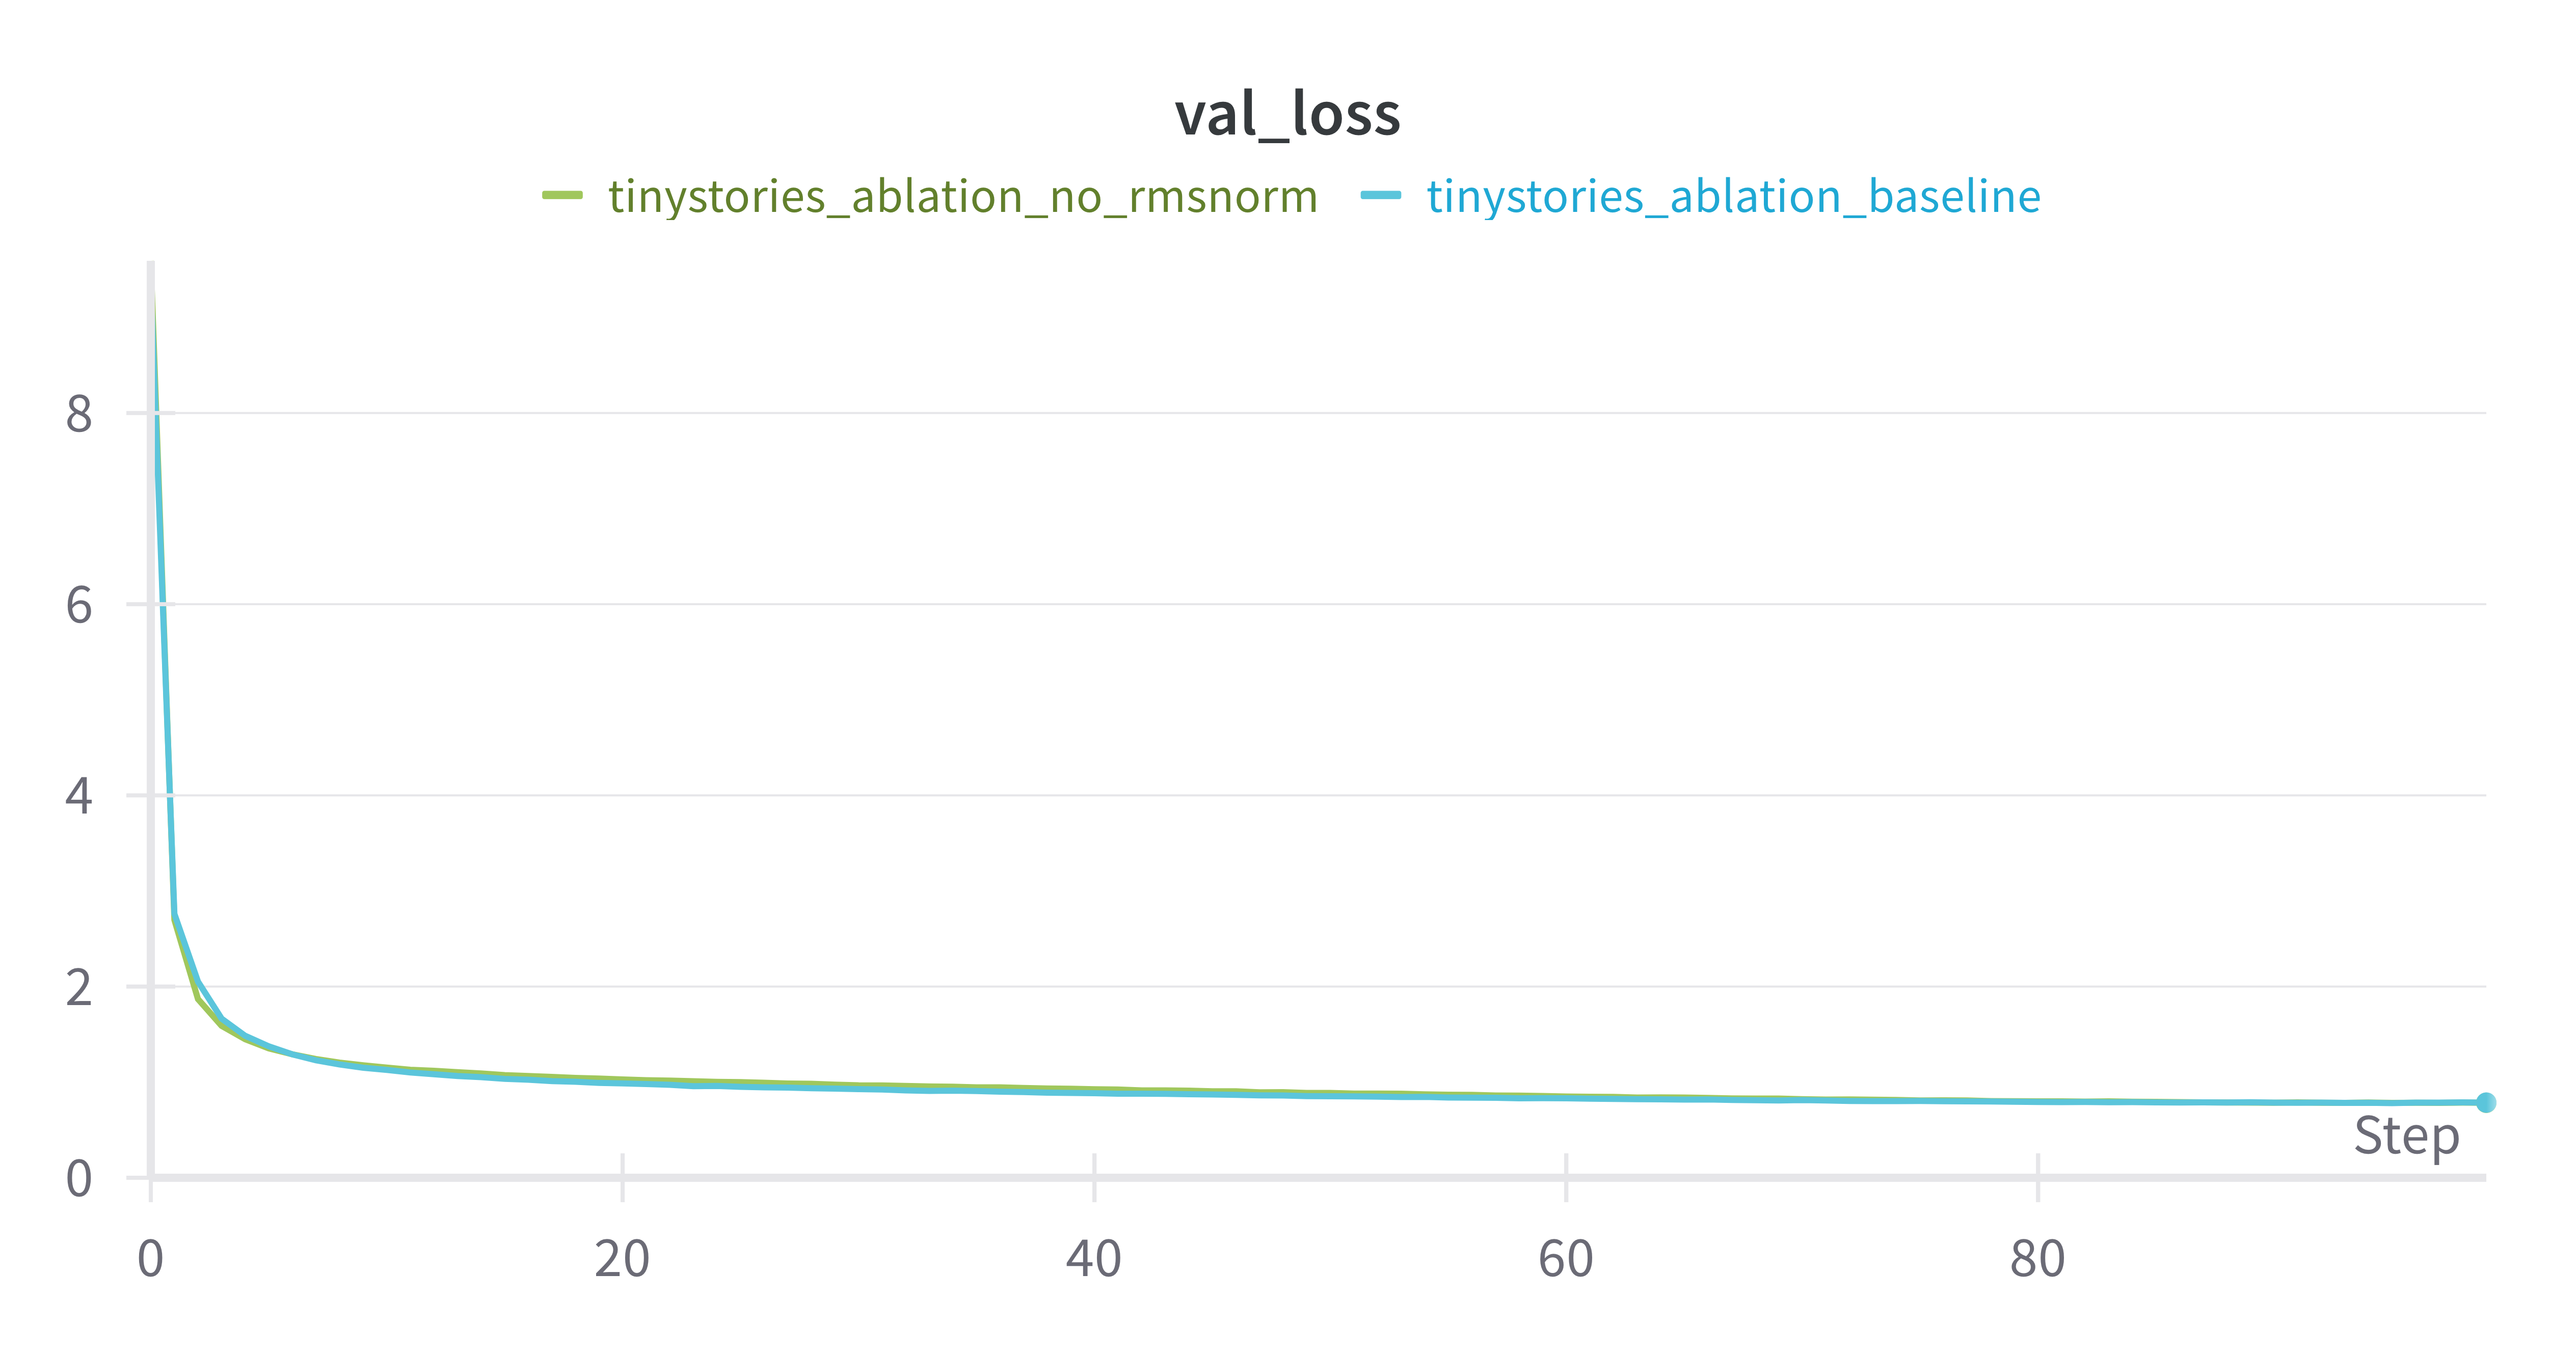

In my experiment, I find the validation loss is basically the same. Numerically, the treatment has slightly worse loss. I think if we scale the learning rate, the performance will be worse for treatment.

### 13. Post-norm ablation